In [15]:
import sys
sys.path.append('..') # Add the parent directory to the Python path

In [16]:
from sklearn import datasets
iris = datasets.load_iris()
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch
from compute_error import compute_error_norms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data defintion

In [17]:
# remove virginica class
data_X = iris.data[iris.target != 2]
data_X = data_X[:, :2]  # only 2 features
# 1 if class is virginica, -1 if class is setosa
data_y = np.array([1 if i == 1 else -1 for i in iris.target[iris.target != 2]])

Utilization of only 10 data points for semplicty

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

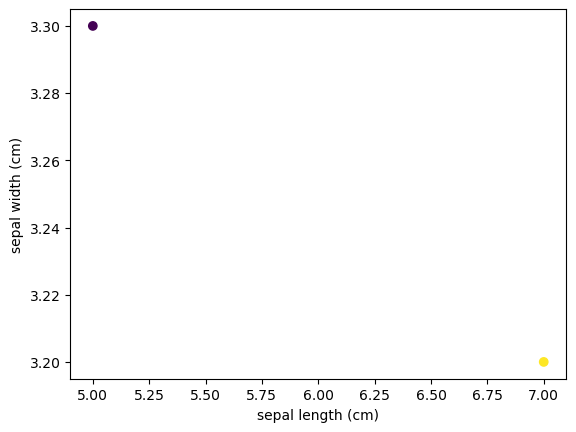

In [18]:
num_samples = 2
tot_samples = len(data_X)

data_X = data_X[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]
data_y = data_y[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]

_, ax = plt.subplots()
scatter = ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

ODE defintion

In [19]:
data_X_T = torch.tensor(data_X).to(torch.float32).to(device)
data_y_T = torch.tensor(data_y).to(torch.float32).view(-1,1).to(device)

def ODE(t, y):
    
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    w = y[:data_X_T.shape[1]]
    b = y[data_X_T.shape[1]]
    u = y[data_X_T.shape[1] + 1:]

    # Create df without in-place modification
    df_w = w 
    df_b = torch.tensor([0.0], dtype=torch.float32).to(device)  # Make sure it's the same dtype and on the right device

    # Concatenate df_w and df_b to create df
    df = torch.cat((df_w, df_b)).view(-1, 1).to(device)
    
    w = w.view(-1, 1)
    u = u.view(-1, 1)
    
    dg = -data_X_T * data_y_T.view(-1, 1)
    dg = torch.cat((dg, -data_y_T), dim=1).to(device)
    
    g = -data_y_T * (torch.matmul(data_X_T, w).to(device) + b) + 1
    u_ = torch.maximum((u + g), torch.zeros(g.shape).to(device)).to(device)
    
    # Differential equations
    dxdt = -df - torch.matmul(dg.T, u_).to(device)
    dudt = (-u + u_) / 2
    
    return torch.cat((dxdt, dudt), dim=0).squeeze(-1).to(device)

# Assuming x and u are defined as follows:
x = torch.ones(3)
x[0] = 0
x[2] = 0
u = torch.zeros(len(data_y_T))

# Concatenate x and u
y_0 = torch.cat((x, u)).to(device)

In [20]:
T = 60
ode = {'name': 'svm', 'func': ODE, 'y0': y_0, 'T': T, 'dim': len(y_0)}

In [21]:
from PINN import pin_base_exe, pin_MLP_exe, pin_new_arc_exe, pin_new_arc_MLP_exe

In [22]:
model, total_iter = pin_new_arc_MLP_exe(net_size=(6, 100), lr=1e-4, batch_size=10000,
                                   ode=ode, stopping_loss=1e-4, device=device, max_iter=1000)

Iteration 0, Loss: 0.00768039608374238, Min w: 0.0
Iteration 10, Loss: 0.004450535401701927, Min w: 0.0
Iteration 20, Loss: 0.0015506147174164653, Min w: 0.0
Iteration 30, Loss: 0.0003188601112924516, Min w: 0.0
Iteration 40, Loss: 0.0001461441133869812, Min w: 0.0
Iteration 50, Loss: 0.0001902492222143337, Min w: 0.0
Iteration 60, Loss: 0.0001522768579889089, Min w: 0.0
Iteration 70, Loss: 0.00014667869254481047, Min w: 0.0
Iteration 80, Loss: 0.00015465800242964178, Min w: 0.0
Iteration 90, Loss: 0.00014845211990177631, Min w: 0.0
Iteration 100, Loss: 0.00014906362048350275, Min w: 0.0
Iteration 110, Loss: 0.00014892526087351143, Min w: 0.0
Iteration 120, Loss: 0.00014390746946446598, Min w: 0.0
Iteration 130, Loss: 0.00013691048661712557, Min w: 0.0
Iteration 140, Loss: 0.0001369080418953672, Min w: 0.0
Iteration 150, Loss: 0.0001365937787340954, Min w: 0.0
Iteration 160, Loss: 0.00013799354201182723, Min w: 0.0
Iteration 170, Loss: 0.0001376965519739315, Min w: 0.0
Iteration 180, L

In [23]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()

In [24]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def ODE_np(t,y):
    dydt = ODE(t, y)
    return dydt.cpu().numpy()

In [26]:
sol = solve_ivp(ODE_np, (0, T), y_0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

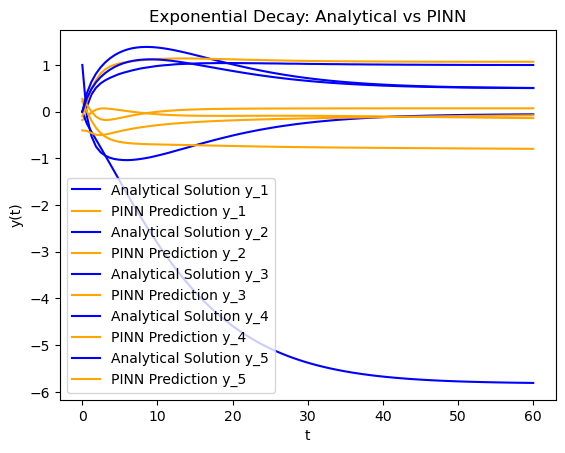

In [27]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()

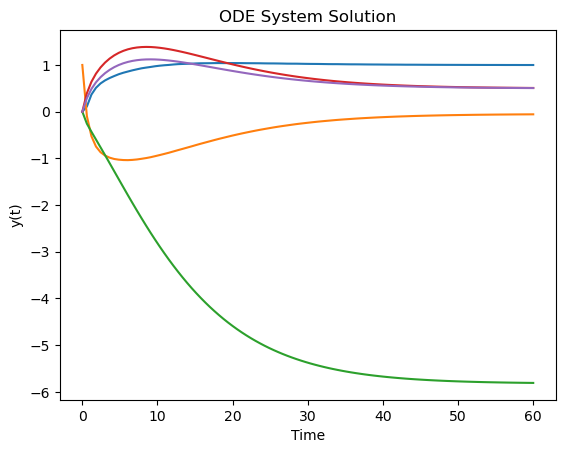

In [14]:
# Extract the solution
t_values = sol.t
y_values = sol.y

# If you want to see the solution
import matplotlib.pyplot as plt

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

In [ ]:
res = y_values[:,-1]

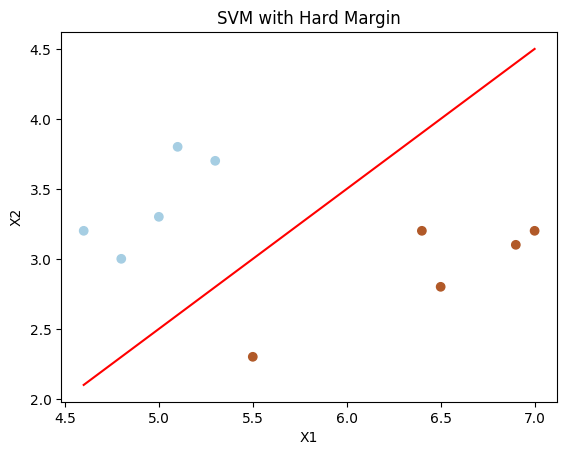

In [ ]:
w = res[0:2]
b = res[2]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w[0] / w[1]) * x_plot - b / w[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Neural network resolution

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.func import functional_call, grad, vmap
import torch

from IPython import display
import time
print(torch.cuda.is_available())

False


In [ ]:
de = DE_NN(data_X, data_y, 0, 100, y_0, 0.001)

In [ ]:
y_best, loss_list, OuC_list = de.train(2000, 100)

In [ ]:
w = y_best[0:2]
b = y_best[2]

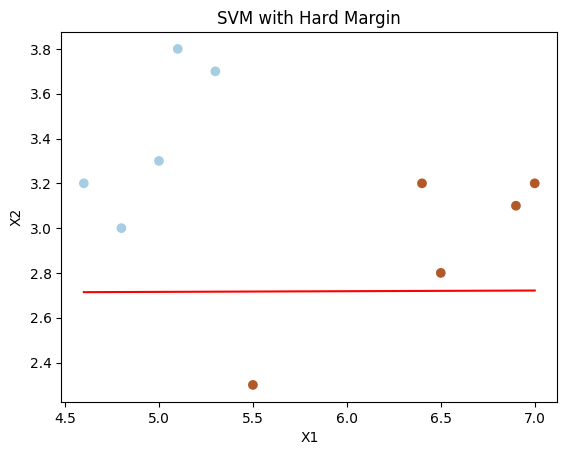

In [ ]:
# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w[0] / w[1]) * x_plot - b / w[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()